In [1]:
%gui qt5
import datetime
from collections import defaultdict
import ibapi
from tws_async import TWSClientQt, iswrapper, util, Stock

util.logToConsole()

In [2]:
# sample application
class TWS(TWSClientQt):
    def __init__(self):
        TWSClientQt.__init__(self)
        self._reqIdSeq = 0
        self._histData = defaultdict(list)

    def popHistData(self, reqId):
        """
        Remove and return the historical data that was downloaded for the given reqId.
        """
        return self._histData.pop(reqId)
    
    @iswrapper
    def tickPrice(self, reqId: int,
            tickType: ibapi.ticktype.TickType,
            price: float,
            attrib: ibapi.common.TickAttrib):
        print('{} price {}'.format(reqId, price))

    @iswrapper
    def tickSize(self, reqId: int,
            tickType: ibapi.ticktype.TickType,
            size: int):
        print('{} size {}'.format(reqId, size))

    @iswrapper
    def historicalData(self, reqId: int, date: str, open: float, high: float,
            low: float, close: float, volume: int, barCount: int,
            WAP: float, hasGaps: int):
        self._histData[reqId].append((date, open, high, low, close, volume))
        
    @iswrapper
    def historicalDataEnd(self, reqId: int, start: str, end: str):
        print('Historical request {} is finished'.format(reqId))


if 'tws' in locals():
    tws.disconnect()
tws = TWS()
tws.connect('127.0.0.1', 7497, clientId=1)

2017-06-23 22:24:57,210 TWSClientQt INFO Connecting to 127.0.0.1:7497 with clientId 1...
2017-06-23 22:24:57,228 TWSClientQt INFO Logged on to server version 112
2017-06-23 22:24:57,231 root ERROR ERROR -1 2104 Market data farm connection is OK:eufarm
2017-06-23 22:24:57,231 root ERROR ERROR -1 2104 Market data farm connection is OK:cashfarm
2017-06-23 22:24:57,232 root ERROR ERROR -1 2104 Market data farm connection is OK:usfarm
2017-06-23 22:24:57,232 root ERROR ERROR -1 2106 HMDS data farm connection is OK:ushmds


In [3]:
# request historical bar data
contract = Stock('TSLA')
reqId = tws.getReqId()
tws.reqHistoricalData(reqId, contract,
        endDateTime=datetime.datetime.utcnow().strftime('%Y%m%d %H:%M:%S UTC'),
        durationStr='60 D',
        barSizeSetting='1 hour',
        whatToShow='TRADES',
        useRTH=False,
        formatDate=1,
        chartOptions=None)

Historical request 488 is finished


In [4]:
# fetch data when it's finished
data = tws.popHistData(reqId)

In [5]:
# process data
import pandas as pd  
df = pd.DataFrame.from_records(data)
df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
df['datetime'] =  pd.to_datetime(df['datetime'])
# df.set_index('datetime', inplace=True)
display(df.head())
display(df.tail())

,datetime,open,high,low,close,volume
0,2017-03-30 14:00:00,277.26,277.76,277.26,277.65,27
1,2017-03-30 15:00:00,277.59,282.00,277.21,280.72,11216
2,2017-03-30 16:00:00,280.86,281.37,279.21,280.13,7182
3,2017-03-30 17:00:00,280.17,281.60,278.81,278.90,6006
4,2017-03-30 18:00:00,278.80,279.59,278.42,278.68,2388


,datetime,open,high,low,close,volume
937,2017-06-23 18:00:00,385.58,385.58,383.01,383.82,4575
938,2017-06-23 19:00:00,383.82,384.50,383.61,383.80,3449
939,2017-06-23 20:00:00,383.81,385.10,382.23,382.53,5242
940,2017-06-23 21:00:00,382.65,384.60,382.01,383.23,7657
941,2017-06-23 22:00:00,383.18,383.50,383.00,383.02,2675


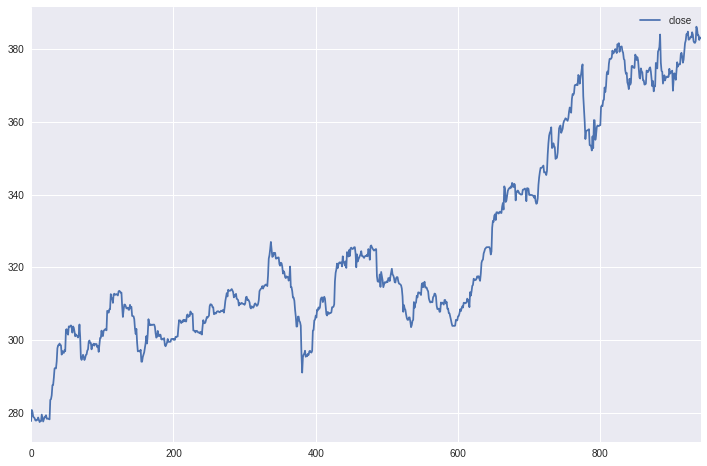

In [6]:
# plot data
%matplotlib inline
import seaborn as sns
df.plot(y='close', figsize=(12,8))

In [7]:
# subscribe to realtime tick data
reqId = tws.getReqId()
tws.reqMktData(reqId, contract, genericTickList='', snapshot=False,
        regulatorySnapshot=False, mktDataOptions=[])

489 price 383.02
489 size 1
489 size 1
489 size 52869
489 price 386.99
489 price 379.35
489 price 382.61
489 price 382.45
489 price 383.02
489 size 1
489 price 383.25
489 size 10
489 size 1
489 size 10


In [8]:
# cancel realtime ticks
tws.cancelMktData(reqId)

In [9]:
# asyncio integration
import asyncio
import quamash

async def coro(seconds):
    print('starting coroutine...')
    await asyncio.sleep(seconds)
    print('coroutine finished')

loop = quamash.QEventLoop()
asyncio.set_event_loop(loop)

task = asyncio.ensure_future(coro(seconds=1))
# note that the Qt event loop doesn't need to be started as it's already running

2017-06-23 22:25:10,980 quamash INFO Using Qt Implementation: PyQt5


starting coroutine...
coroutine finished
